In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch
from torch import nn
import numpy as np
sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from pathlib import Path
from typing import Dict
from ml_utilities.torch_models.base_model import BaseModel
from ml_utilities.torch_models.fc import FC
from ml_utilities.torch_models import get_model_class
from omegaconf import OmegaConf

from erank.utils import load_directions_matrix_from_task_sweep
import matplotlib.pyplot as plt
gpu_id = 0

/home/max/anaconda3/envs/erank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load matrix

In [2]:
# p = '/system/user/beck/pwbeck/projects/regularization/erank/outputs/f_mnist-2.0-taskidxXXX_260622_110634/outputs'
# p = './../res/f_mnist_pretrained/outputs'
# dir_matrix = load_directions_matrix_from_task_sweep(p, device=gpu_id, save_name_num_epoch_digits=3)
dir_matrix = torch.normal(0,1,size=(10,1000))
dir_matrix.requires_grad_(True)

tensor([[-0.8000, -0.2831, -1.4592,  ..., -0.6020,  0.3358,  0.0737],
        [ 0.0941,  0.4440, -1.4884,  ..., -0.3196, -0.1556,  0.9364],
        [ 1.1720, -0.8668, -1.7011,  ...,  1.3153, -0.4587, -0.3471],
        ...,
        [-2.3251, -1.9047,  0.5270,  ..., -0.6056,  1.7208,  0.6652],
        [-0.2494, -0.6387, -0.2338,  ...,  0.5289,  2.1146,  0.5236],
        [ 0.0325,  1.2585, -0.6127,  ..., -0.9829, -0.0641,  0.1679]],
       requires_grad=True)

In [3]:
dir_matrix.shape, dir_matrix.device, dir_matrix.requires_grad, torch.linalg.norm(dir_matrix, dim=1, keepdim=True)

(torch.Size([10, 1000]),
 device(type='cpu'),
 True,
 tensor([[32.2824],
         [32.8590],
         [31.7697],
         [31.7939],
         [31.2276],
         [31.2451],
         [32.0688],
         [31.6769],
         [31.0421],
         [31.7933]], grad_fn=<CopyBackwards>))

## erank function

In [4]:
def erank(matrix_A: torch.Tensor, center_matrix_A: bool=False) -> torch.Tensor:
        """Calculates the effective rank of a matrix.

        Args:
            matrix_A (torch.Tensor): Matrix of shape m x n. 
            center_matrix_A (bool): Center the matrix 

        Returns:
            torch.Tensor: Effective rank of matrix_A
        """
        assert matrix_A.ndim == 2
        _, s, _ = torch.pca_lowrank(matrix_A, center=center_matrix_A, niter=1, q=min(matrix_A.shape[0], matrix_A.shape[1]))
        # s = torch.square(s) / (s.shape[0] - 1)

        # normalizes input s -> scale independent!
        return torch.exp(torch.distributions.Categorical(s).entropy())

In [5]:
er = erank(dir_matrix)
er

tensor(9.9865, grad_fn=<ExpBackward0>)

In [6]:
# er.backward()

## How does the gradient of the erank look like?

Context: During the experiments with erank regularized Reptile I encountered issues with Inf loss values due to (very likely) Inf gradients. 
These Inf gradients occured when we evaulated the erank at the origin. In the first inner iteration we subtract the base model from the current model parameters. This results to a zero vector.
Hypothesis: 
The erank is not continuous differentiable! Especially not at the origin. Check this.

In [7]:
norm_dir_matrix = dir_matrix / torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True)

In [8]:
# torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True), torch.linalg.norm(norm_dir_matrix, ord=2, dim=1, keepdim=True)

In [9]:
erank(dir_matrix), erank(norm_dir_matrix)

(tensor(9.9865, grad_fn=<ExpBackward0>),
 tensor(9.9878, grad_fn=<ExpBackward0>))

## How sensitive is the erank and its gradient to changes in the update vector? Specifically, the norm:

Here the erank and the singular values of the matrix = cat([pretrain_diffs, [norm_vec, 0,0, ...]]) is calculated.



In [10]:
norm_update_vec = 0.0

delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
delta[0] = norm_update_vec
delta.requires_grad_(True)
matrix1 = torch.cat([delta, dir_matrix], dim=0)
_, s, _ = torch.svd_lowrank(matrix1)
erank_val = erank(matrix1)
erank_val.backward()
erank_grad_norm = torch.linalg.norm(delta.grad)
s, erank_val, erank_grad_norm

(tensor([33.8919, 33.3706, 32.3744, 32.0439, 31.3361, 30.7127],
        grad_fn=<SvdHelperBackward0>),
 tensor(9.9865, grad_fn=<ExpBackward0>),
 tensor(2060716.8750))

In [11]:
norm_update_vec = 5.0

delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
delta[0] = norm_update_vec
delta.requires_grad_(True)
matrix1 = torch.cat([delta, dir_matrix], dim=0)
_, s, _ = torch.svd_lowrank(matrix1)
erank_val = erank(matrix1)
erank_val.backward()
erank_grad_norm = torch.linalg.norm(delta.grad)
s, erank_val, erank_grad_norm

(tensor([158.1508,  33.7361,  33.1965,  32.8634,  31.4849,  30.5515],
        grad_fn=<SvdHelperBackward0>),
 tensor(8.7726, grad_fn=<ExpBackward0>),
 tensor(0.0198))

The erank is sensitive to length of update vectors.

## erank plotting functions

In [12]:
# This generates values for erank plots.
# It analyzes the erank of a matrix if the norm of one vector is increased.

# I use the directions matrix (i.e. concatenated models) and concatenate one vector which has only one entry. 
# This vector spans a one-dimensional space (a line). The value of this entry is increased.

def erank_sv_norm_update_vector_sweep(dir_matrix, update_vec, normalize_dir_matrix: bool = False, xlim_logscale=[-10,4], n_points=30):
    assert update_vec.shape == (1, dir_matrix.shape[1])
    dir_matrix.requires_grad_(False)
    erank_vals = []
    erank_grad_norm_vals = []
    singular_vals = []
    vec_norms = torch.logspace(xlim_logscale[0], xlim_logscale[1], n_points)
    for n in vec_norms:
        delta = update_vec.to(dir_matrix)
        delta = n*delta
        delta.requires_grad_(True)
        matrix1 = torch.cat([delta, dir_matrix], dim=0)
        if normalize_dir_matrix:
            # normalize matrix
            matrix1 = matrix1 / torch.linalg.norm(matrix1, ord=2, dim=1, keepdim=True)
        # calculate erank
        erank_val = erank(matrix1)
        erank_vals.append(erank_val.item())
        # calculate erank grad norm
        erank_val.backward()
        erank_grad_norm_vals.append(torch.linalg.norm(delta.grad).item())
        # calculate singular values
        _, s, _ = torch.svd_lowrank(matrix1)
        singular_vals.append(s.detach().cpu().numpy())
        ret_dict = {
            'vec_norms': vec_norms,
            'erank_vals': erank_vals,
            'singular_vals': singular_vals,
            'erank_grad_norm_vals': erank_grad_norm_vals
        }
    return ret_dict

In [13]:
def make_plot(out_subspace: Dict[str, float], in_subspace: Dict[str, float], singular_values_ylim=[20,1000], erank_ylim=[0,13]):
    fig = plt.figure(figsize=(25,14))
    fig.suptitle('First row: direction outside subspace | Second row: direction inside subspace')
    vec_norms = out_subspace['vec_norms']
    plt.subplot(2,3,1)
    plt.plot(vec_norms, out_subspace['erank_vals'], 'o-')
    plt.xscale('log')
    plt.ylabel('erank')
    plt.xlabel('norm update vector')
    plt.title('erank of normalized matrix')
    plt.ylim(erank_ylim)
    
    plt.subplot(2,3,2)
    plt.plot(vec_norms, out_subspace['erank_grad_norm_vals'], 'o-')
    plt.xscale('log')
    plt.ylabel('grad norm erank')
    plt.xlabel('norm update vector')
    plt.title('gradient norm of concatenated vector')
    
    plt.subplot(2,3,3)
    plt.plot(vec_norms, out_subspace['singular_vals'], 'o-')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('singular value')
    plt.xlabel('norm update vector')
    plt.title('singular values of normalized matrix')
    plt.ylim(singular_values_ylim)
    
    plt.subplot(2,3,4)
    plt.plot(vec_norms, in_subspace['erank_vals'], 'o-')
    plt.xscale('log')
    plt.ylabel('erank')
    plt.xlabel('norm update vector')
    plt.title('erank of normalized matrix')
    plt.ylim(erank_ylim)
    
    plt.subplot(2,3,5)
    plt.plot(vec_norms, in_subspace['erank_grad_norm_vals'], 'o-')
    plt.xscale('log')
    plt.ylabel('grad norm erank')
    plt.xlabel('norm update vector')
    plt.title('gradient norm of concatenated vector')
    
    plt.subplot(2,3,6)
    plt.plot(vec_norms, in_subspace['singular_vals'], 'o-')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('singular value')
    plt.xlabel('norm update vector')
    plt.title('singular values of normalized matrix')
    plt.ylim(singular_values_ylim)

## Unnormalized Direction Matrix M - axis parallel dir

(False, False)

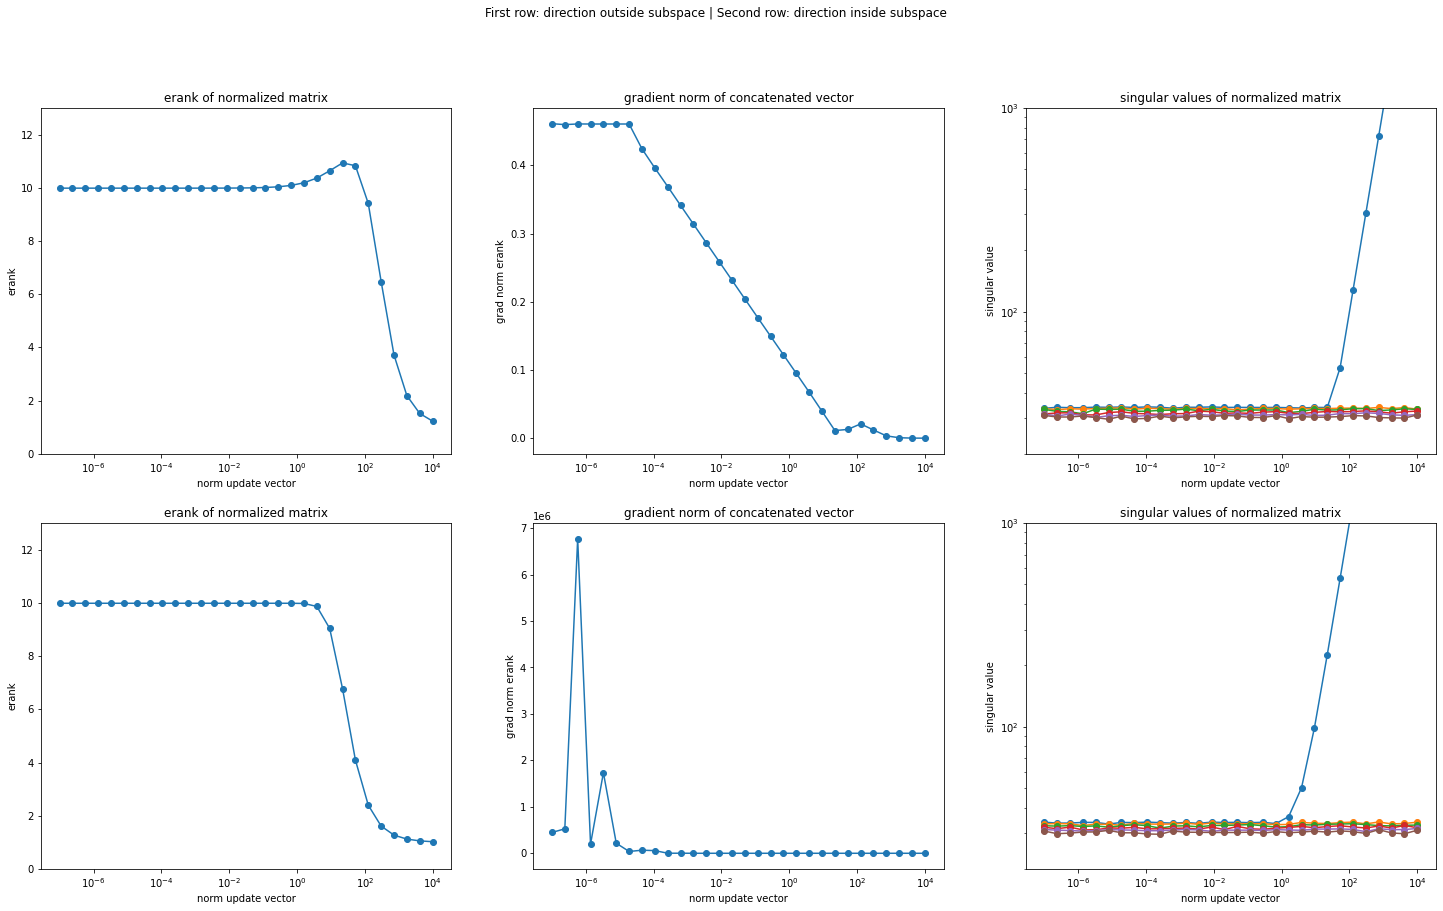

In [20]:
xlim_logscale=[-7,4]
normalize_dir_matrix=False
# outside subspace: axis parallel direction
update_vec1 = torch.zeros(size=(1, dir_matrix.shape[1]), requires_grad=False)
update_vec1[0,0] = 1.
out_subspace = erank_sv_norm_update_vector_sweep(dir_matrix, update_vec1, normalize_dir_matrix=normalize_dir_matrix, xlim_logscale=xlim_logscale)
# inside subspace: mean vec of dir_matrix
update_vec2 = dir_matrix.mean(dim=0, keepdim=True)
in_subspace = erank_sv_norm_update_vector_sweep(dir_matrix, update_vec2, normalize_dir_matrix=normalize_dir_matrix, xlim_logscale=xlim_logscale)
make_plot(out_subspace, in_subspace)
np.isnan(np.array(out_subspace['erank_grad_norm_vals'])).any(),np.isnan(np.array(in_subspace['erank_grad_norm_vals'])).any()

## Normalized Direction Matrix M - axis parallel dir

(False, False)

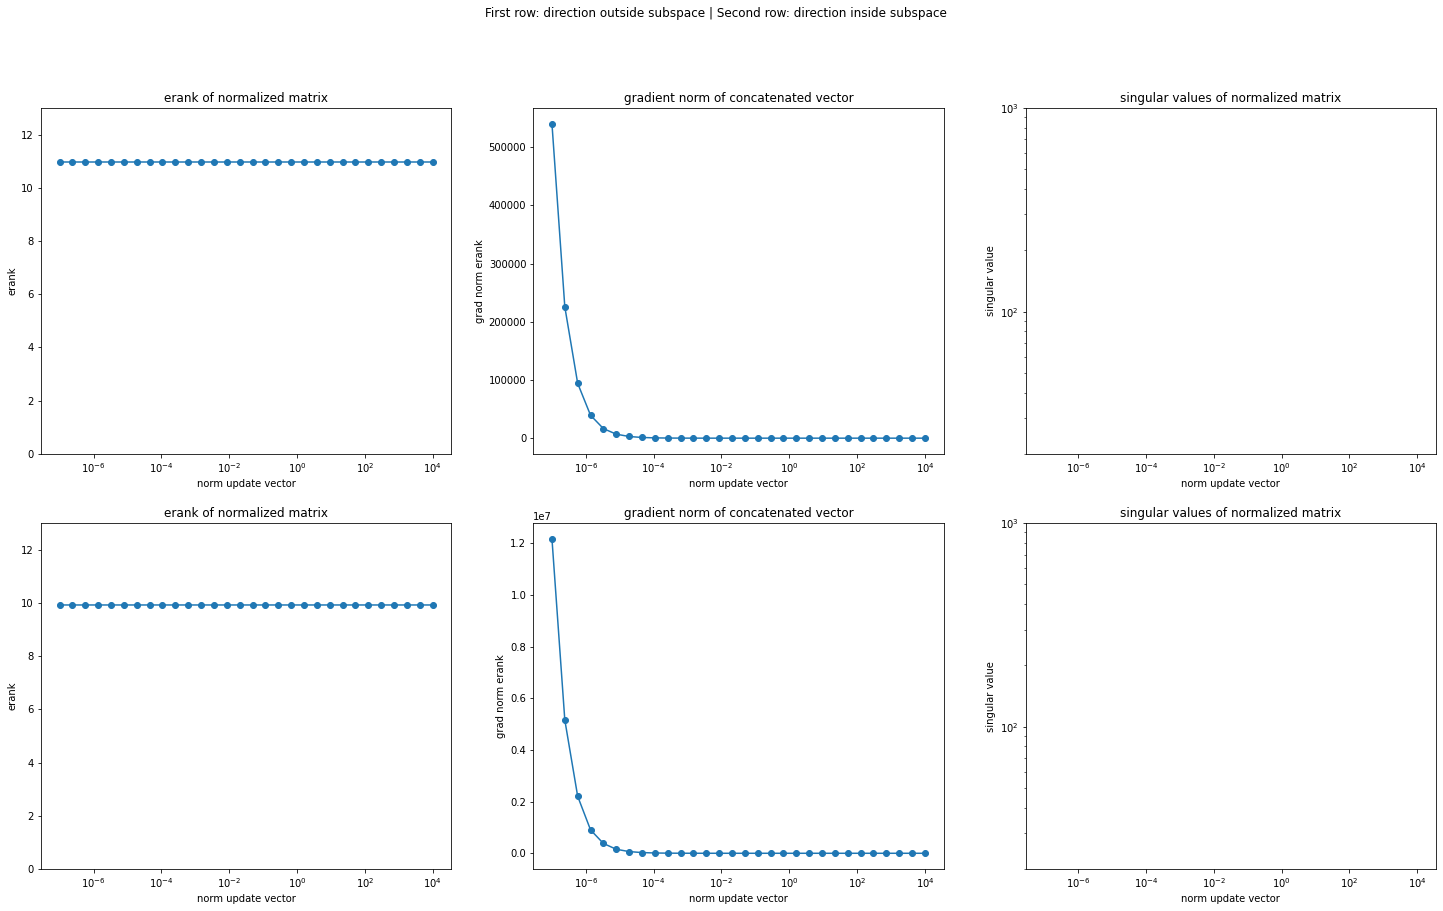

In [15]:
xlim_logscale=[-7,4]
normalize_dir_matrix=True
# outside subspace: axis parallel direction
update_vec1 = torch.zeros(size=(1, dir_matrix.shape[1]), requires_grad=False)
update_vec1[0,0] = 1.
out_subspace = erank_sv_norm_update_vector_sweep(dir_matrix, update_vec1, normalize_dir_matrix=normalize_dir_matrix, xlim_logscale=xlim_logscale)
# inside subspace: mean vec of dir_matrix
update_vec2 = dir_matrix.mean(dim=0, keepdim=True)
in_subspace = erank_sv_norm_update_vector_sweep(dir_matrix, update_vec2, normalize_dir_matrix=normalize_dir_matrix, xlim_logscale=xlim_logscale)
make_plot(out_subspace, in_subspace)
np.isnan(np.array(out_subspace['erank_grad_norm_vals'])).any(),np.isnan(np.array(in_subspace['erank_grad_norm_vals'])).any()

## Unnormalized M - Random direction

(False, True)

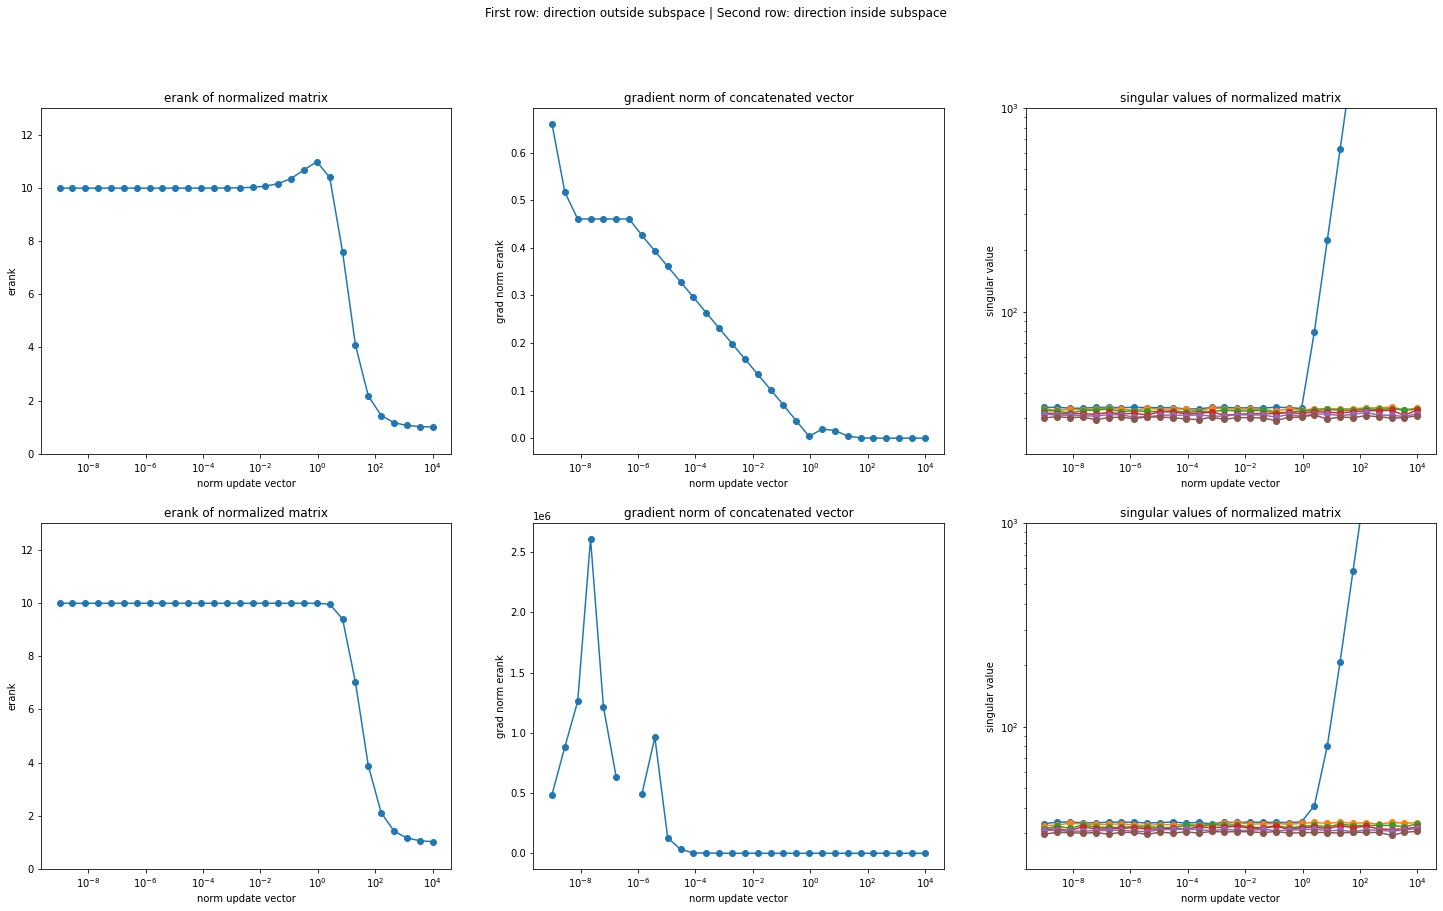

In [16]:
xlim_logscale=[-9,4]
normalize_dir_matrix=False
# outside subspace: axis parallel direction
update_vec1 = torch.normal(0, 1, size=(1, dir_matrix.shape[1]), requires_grad=False)
out_subspace = erank_sv_norm_update_vector_sweep(dir_matrix, update_vec1, normalize_dir_matrix=normalize_dir_matrix, xlim_logscale=xlim_logscale)
# inside subspace: mean vec of dir_matrix
update_vec2 = dir_matrix.mean(dim=0, keepdim=True)
in_subspace = erank_sv_norm_update_vector_sweep(dir_matrix, update_vec2, normalize_dir_matrix=normalize_dir_matrix, xlim_logscale=xlim_logscale)
make_plot(out_subspace, in_subspace)
np.isnan(np.array(out_subspace['erank_grad_norm_vals'])).any(),np.isnan(np.array(in_subspace['erank_grad_norm_vals'])).any()

### Conclusion
In this notebook we analyzed the norm of the gradients of the erank with respect to the (concatenated) update vector. The motivation were the non-smooth behavior of the erank around the origin. We want to find out how we can perturb the parameters such that we stay in the smooth region of the erank.

The erank function looks differently, depending on the direction of the input parameter (See especially the plots for the unnormalized directions matrix M):
- If we go in directions outside the subspace, the erank function has a peak at around the lengths of the other vectors.
- If we go in directions inside the subspace, this peak does not occur.

This has some implications for the noise we want to add:
We assume that a random Gauss vector is not inside the subspace. We add a random Normal distributed vector scaled by epsilon = 1e-6 to avoid numeric instabilities.

The observations are made with a random normal distributed direction matrix (a random subspace) and a subspace spanned by pretrained models on f_mnist.